In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [96]:
data = pd.read_csv("data/label.csv")

In [97]:
data.head(3)

,id,from,subject,date,snippet,text,label
0,199ead51e3bab605,GoDaddy <email@e.godaddy.com>,.IN and .CO.IN domains for just ₹299!,2025-10-16 02:20:02+00:00,"Act fast, end of year savings are only availab...",.IN and .CO.IN domains for just ₹299! Act fast...,PROMOTION
1,191f0d4f885c68bb,AJIO <alert@mailer.ajio.in>,Expiring Soon: AJIO Perks Worth 200 Points,2024-09-14 13:59:32+00:00,Don&#39;t miss shopping at the AJIO All Stars ...,Expiring Soon: AJIO Perks Worth 200 Points Don...,PROMOTION
2,194fbf2b18676a62,Google AI Studio <googleaistudio-noreply@googl...,"Varun reddy, design prompts with Google AI Studio",2025-02-12 20:56:13+00:00,Craft compelling prompts for powerful AI resul...,"Varun reddy, design prompts with Google AI Stu...",PROMOTION


In [98]:
df=data[['text','label']]
df.head(3)

,text,label
0,.IN and .CO.IN domains for just ₹299! Act fast...,PROMOTION
1,Expiring Soon: AJIO Perks Worth 200 Points Don...,PROMOTION
2,"Varun reddy, design prompts with Google AI Stu...",PROMOTION


In [99]:
df.shape

(1800, 2)

In [100]:
df['label'].unique()

<StringArray>
['PROMOTION', 'TRASH', 'IMPORTANT', 'OFFICIAL', 'INFORMATION']
Length: 5, dtype: str

In [101]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [102]:
df['label'].value_counts()

label
PROMOTION      908
INFORMATION    451
OFFICIAL       269
TRASH          121
IMPORTANT       51
Name: count, dtype: int64

## pre-processing and cleaning

In [129]:
import re
#import nltk
#from nltk.corpus import stoprwords
from bs4 import BeautifulSoup

# TEXT CLEANING FUNCTION (EMAIL / NLP SAFE)
def clean_text(text):
    text = str(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags only if present
    if '<' in text and '>' in text:
        text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# APPLY ONCE
df['text'] = df['text'].apply(clean_text)


In [ ]:
"""import re
from bs4 import BeautifulSoup

def clean_text(text):
    """
    Balanced text cleaning suitable for:
    - Classical ML (TF-IDF, Logistic, SVM)
    - Transformer models (BERT family)
    - Email classification tasks
    """

    if text is None:
        return ""

    text = str(text)

    # 1️⃣ Remove HTML safely
    if '<' in text and '>' in text:
        text = BeautifulSoup(text, "html.parser").get_text(separator=" ")

    # 2️⃣ Replace URLs with token (keep signal)
    text = re.sub(r'http\S+|www\S+', ' URLTOKEN ', text)

    # 3️⃣ Replace email addresses with token
    text = re.sub(r'\S+@\S+', ' EMAILTOKEN ', text)

    # 4️⃣ Replace numbers with token (optional but good for emails)
    text = re.sub(r'\d+', ' NUMBERTOKEN ', text)

    # 5️⃣ Remove excessive punctuation (keep basic ones)
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # 6️⃣ Lowercase (safe for most cases; remove if using cased BERT)
    text = text.lower()

    # 7️⃣ Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
"""

In [130]:
df.head(5)

,text,label
0,in and co in domains for just act fast end of ...,PROMOTION
1,expiring soon ajio perks worth points don t mi...,PROMOTION
2,varun reddy design prompts with google ai stud...,PROMOTION
3,final hours sale ends tonight last call sale e...,PROMOTION
4,improve your coding skills with say hello worl...,PROMOTION


In [131]:
X_text = df['text']
y = df['label']

In [132]:
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
y = le.fit_transform(df["label"])   # df["label"] is TEXT

# Save encoder
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [134]:
import pandas as pd

counts = pd.Series(y).value_counts().sort_values()
print(counts)


0     51
4    121
2    269
1    451
3    908
Name: count, dtype: int64


In [135]:
counts = pd.Series(y).value_counts()
valid_classes = counts[counts >= 2].index

mask = pd.Series(y).isin(valid_classes)

X_text = X_text[mask]
y = y[mask]


In [136]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [137]:
y

array([3, 3, 3, ..., 1, 2, 3], shape=(1800,))

In [138]:
# 4. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

"""vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True,
    max_features=8000,
    
)"""
vectorizer = TfidfVectorizer(
    max_features=30000,   # LIMIT THIS
    ngram_range=(1,2),
    sublinear_tf=True,
    min_df=3,
    max_df=0.95
)


In [139]:
lengths = [len(str(t)) for t in X_train_text]
print("Max length:", max(lengths))
print("Average length:", sum(lengths)/len(lengths))


Max length: 353
Average length: 194.84027777777777


In [140]:
X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

In [115]:
#PRINT(3/0)

In [141]:
class_weight = {
    0: 10.0,   # IMPORTANT - 51
    1: 0.9,   # INFORMATION - 451
    2: 1.4,   # OFFICIAL - 269
    3: 0.5,   # PROMOTION  - 908
    4: 2.2    # TRASH - 121
}


'''
{
  0: 7.0,
  1: 0.9,
  2: 1.4,
  3: 0.5,
  4: 3.2
}


class_weight = {
    0: 6.5,   # IMPORTANT - 51
    1: 2.5,   # INFORMATION - 451
    2: 4.0,   # OFFICIAL - 269
    3: 1.0,   # PROMOTION  - 908
    4: 2.0    # TRASH - 121
}


0     51
4    121
2    269
1    451
3    908

label
PROMOTION      908
INFORMATION    451
OFFICIAL       269
TRASH          121
IMPORTANT       51

}'''

'\n{\n  0: 7.0,\n  1: 0.9,\n  2: 1.4,\n  3: 0.5,\n  4: 3.2\n}\n\n\nclass_weight = {\n    0: 6.5,   # IMPORTANT - 51\n    1: 2.5,   # INFORMATION - 451\n    2: 4.0,   # OFFICIAL - 269\n    3: 1.0,   # PROMOTION  - 908\n    4: 2.0    # TRASH - 121\n}\n\n\n0     51\n4    121\n2    269\n1    451\n3    908\n\nlabel\nPROMOTION      908\nINFORMATION    451\nOFFICIAL       269\nTRASH          121\nIMPORTANT       51\n\n}'

In [142]:
# 5. Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=2000,
    class_weight=class_weight,
    C=0.3,
    n_jobs=1              # IMPORTANT
)


model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.3
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 10.0, 1: 0.9, 2: 1.4, 3: 0.5, ...}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wid

### prediction

In [143]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("classification report: \n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[  8   0   0   2   0]
 [  1  66   0  22   1]
 [  0   0  51   3   0]
 [  0  15   7 159   1]
 [  0   1   0   5  18]]
Accuracy: 0.8388888888888889
classification report: 
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.73      0.77        90
           2       0.88      0.94      0.91        54
           3       0.83      0.87      0.85       182
           4       0.90      0.75      0.82        24

    accuracy                           0.84       360
   macro avg       0.86      0.82      0.84       360
weighted avg       0.84      0.84      0.84       360



In [119]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_train = model.predict(X_train)

print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("classification report: \n", classification_report(y_train, y_pred_train))

Confusion Matrix:
 [[ 41   0   0   0   0]
 [  2 299  10  49   1]
 [  1   1 207   6   0]
 [  5  37  26 652   6]
 [  0   3   2  16  76]]
Accuracy: 0.8854166666666666
classification report: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        41
           1       0.88      0.83      0.85       361
           2       0.84      0.96      0.90       215
           3       0.90      0.90      0.90       726
           4       0.92      0.78      0.84        97

    accuracy                           0.89      1440
   macro avg       0.88      0.89      0.88      1440
weighted avg       0.89      0.89      0.88      1440



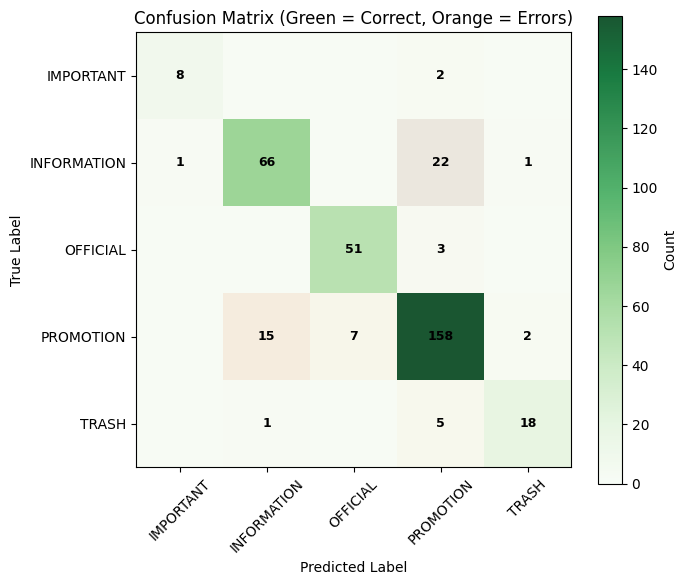

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_names = ["IMPORTANT", "INFORMATION", "OFFICIAL", "PROMOTION", "TRASH"]
n_classes = len(class_names)

plt.figure(figsize=(7, 6))

# masks
correct_mask = np.eye(n_classes)
error_mask = 1 - correct_mask

# plot errors first (orange)
plt.imshow(cm * error_mask, cmap="Oranges", alpha=0.9)

# overlay correct predictions (blue)
plt.imshow(cm * correct_mask, cmap="Greens", alpha=0.9)

plt.title("Confusion Matrix (Green = Correct, Orange = Errors)")
plt.colorbar(label="Count")

ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

# annotate
for i in range(n_classes):
    for j in range(n_classes):
        if cm[i, j] > 0:
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="black",
                fontsize=9,
                fontweight="bold"
            )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [121]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    loss="hinge",        # SVM
    alpha=0.0001,
    class_weight='balanced',
    max_iter=1000
)

sgd.fit(X_train, y_train)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [122]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_sgd = sgd.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sgd))
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("classification report: \n", classification_report(y_test, y_pred_sgd))

Confusion Matrix:
 [[  7   1   0   2   0]
 [  1  66   0  22   1]
 [  0   0  49   5   0]
 [  0  21   9 149   3]
 [  0   2   0   4  18]]
Accuracy: 0.8027777777777778
classification report: 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.73      0.73        90
           2       0.84      0.91      0.88        54
           3       0.82      0.82      0.82       182
           4       0.82      0.75      0.78        24

    accuracy                           0.80       360
   macro avg       0.82      0.78      0.80       360
weighted avg       0.80      0.80      0.80       360



In [123]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1.0)

nb.fit(X_train, y_train)



,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [124]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_nb = nb.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("classification report: \n", classification_report(y_test, y_pred_nb))

Confusion Matrix:
 [[  4   1   0   5   0]
 [  1  62   0  26   1]
 [  0   3  39  12   0]
 [  0  10   6 165   1]
 [  0   2   0  11  11]]
Accuracy: 0.7805555555555556
classification report: 
               precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.79      0.69      0.74        90
           2       0.87      0.72      0.79        54
           3       0.75      0.91      0.82       182
           4       0.85      0.46      0.59        24

    accuracy                           0.78       360
   macro avg       0.81      0.64      0.70       360
weighted avg       0.79      0.78      0.77       360



In [125]:
from sklearn.svm import LinearSVC
# C = [0.3, 1, 3]

clf = LinearSVC(class_weight="balanced", max_iter=2000, C = 2.5)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",2.5
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [126]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_clf = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_clf))
print("Accuracy:", accuracy_score(y_test, y_pred_clf))
print("classification report: \n", classification_report(y_test, y_pred_clf))

Confusion Matrix:
 [[  7   0   0   3   0]
 [  1  66   0  22   1]
 [  0   0  49   5   0]
 [  0  20   8 151   3]
 [  0   2   0   4  18]]
Accuracy: 0.8083333333333333
classification report: 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.73      0.74        90
           2       0.86      0.91      0.88        54
           3       0.82      0.83      0.82       182
           4       0.82      0.75      0.78        24

    accuracy                           0.81       360
   macro avg       0.82      0.78      0.80       360
weighted avg       0.81      0.81      0.81       360



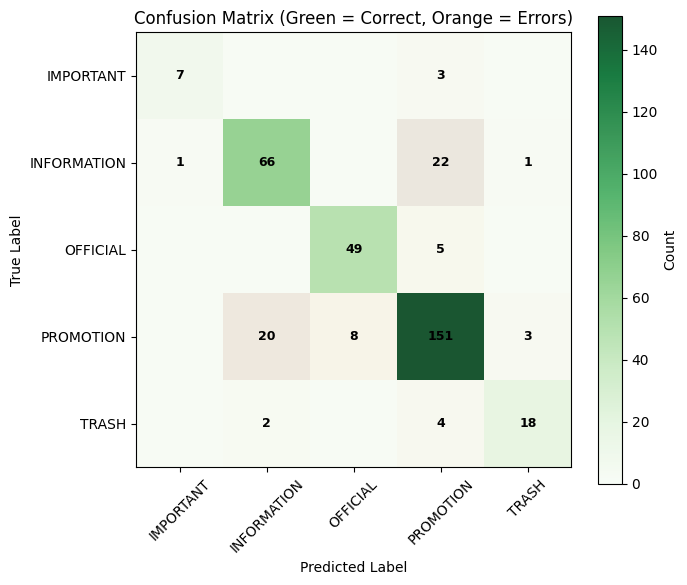

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_clf)

class_names = ["IMPORTANT", "INFORMATION", "OFFICIAL", "PROMOTION", "TRASH"]
n_classes = len(class_names)

plt.figure(figsize=(7, 6))

# masks
correct_mask = np.eye(n_classes)
error_mask = 1 - correct_mask

# plot errors first (orange)
plt.imshow(cm * error_mask, cmap="Oranges", alpha=0.9)

# overlay correct predictions (blue)
plt.imshow(cm * correct_mask, cmap="Greens", alpha=0.9)

plt.title("Confusion Matrix (Green = Correct, Orange = Errors)")
plt.colorbar(label="Count")

ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

# annotate
for i in range(n_classes):
    for j in range(n_classes):
        if cm[i, j] > 0:
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="black",
                fontsize=9,
                fontweight="bold"
            )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [128]:
import joblib

joblib.dump(clf, "email_classifier.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']